In [1]:
import scanpy.api as sc
import pandas as pd 
import numpy as np
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
from nero import Harmonia
from tqdm import tqdm_notebook as tqdm
import warnings
import itertools as it
import pickle as pkl

In [2]:
# might need this, the most recent version of jupterlab I installed installed the most recent version of jedi which has been having problems with autocomplete
# see thread here: https://github.com/ipython/ipython/issues/10493
%config Completer.use_jedi = False
sc.settings.verbosity = 5
sc.settings.set_figure_params(dpi=80)

In [3]:
exps = dict()
for exp in ['liver.all.1','liver.all.2','liver.hepatocytes']:
    exps[exp] = dict()

In [4]:
path_to_parent = '/myvol/data2/data/tabula.muris/'

In [38]:
for exp in exps:
    exps[exp]['adata'] = sc.read_10x_mtx(path_to_parent + exp)

    reading /myvol/data2/data/tabula.muris/liver.all.1/matrix.mtx
--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
    reading /myvol/data2/data/tabula.muris/liver.all.2/matrix.mtx
--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
    reading /myvol/data2/data/tabula.muris/liver.hepatocytes/matrix.mtx
--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.


In [9]:
for exp in exps:
    print(exps[exp]['adata'])
    print(np.unique(exps[exp]['adata'].var_vector(0),return_counts=0))
    print(np.unique(exps[exp]['adata'].var_vector(1),return_counts=0))

AnnData object with n_obs × n_vars = 596 × 23433 
    var: 'gene_ids'
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 15. 16. 17. 19.
 26. 31. 32. 40. 46. 56. 60.]
[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
  15.  16.  17.  25.  27.  47. 106.]
AnnData object with n_obs × n_vars = 322 × 23433 
    var: 'gene_ids'
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 11. 12. 13. 14. 15. 20. 22. 25.
 27. 30. 36. 63. 76.]
[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  25.  26.  28.  29.
  30.  31.  32.  34.  36.  37.  39.  40.  41.  43.  44.  45.  46.  50.
  51.  65.  68.  70.  75.  78.  98. 108. 138. 154. 186. 331.]
AnnData object with n_obs × n_vars = 1006 × 23433 
    var: 'gene_ids'
[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  27.  29.  30.
  33.  34.  38.  39.  40.  46.  49.  54.  56.  58.  70.  76.  80. 

In [10]:
for exp in exps:
    print(exps[exp]['adata'].var_names[np.random.randint(0,23433,5)])

Index(['Cspp1', 'Gm5169', 'Nxnl2', 'Tomm20l', 'Irf4'], dtype='object', name=1)
Index(['Cfd', 'Snhg8', 'Avpr2', 'Syt16', 'Morc1'], dtype='object', name=1)
Index(['Zbtb16', 'Olfr295', 'Fbxw10', 'Prss34', 'Mir3110'], dtype='object', name=1)


In [43]:
def my_plot(ax, vals, tupe, thresh=None, max_y=None):
    ax.hist(vals,bins=np.logspace(np.log10(1000),np.log10(8e3), 200),color='gray') # logspace bins looks great!
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_title(tupe)
    ax.grid(which='both', alpha=0.5)
    if thresh != None:
        ax.vlines(thresh,0,max_y)
    return

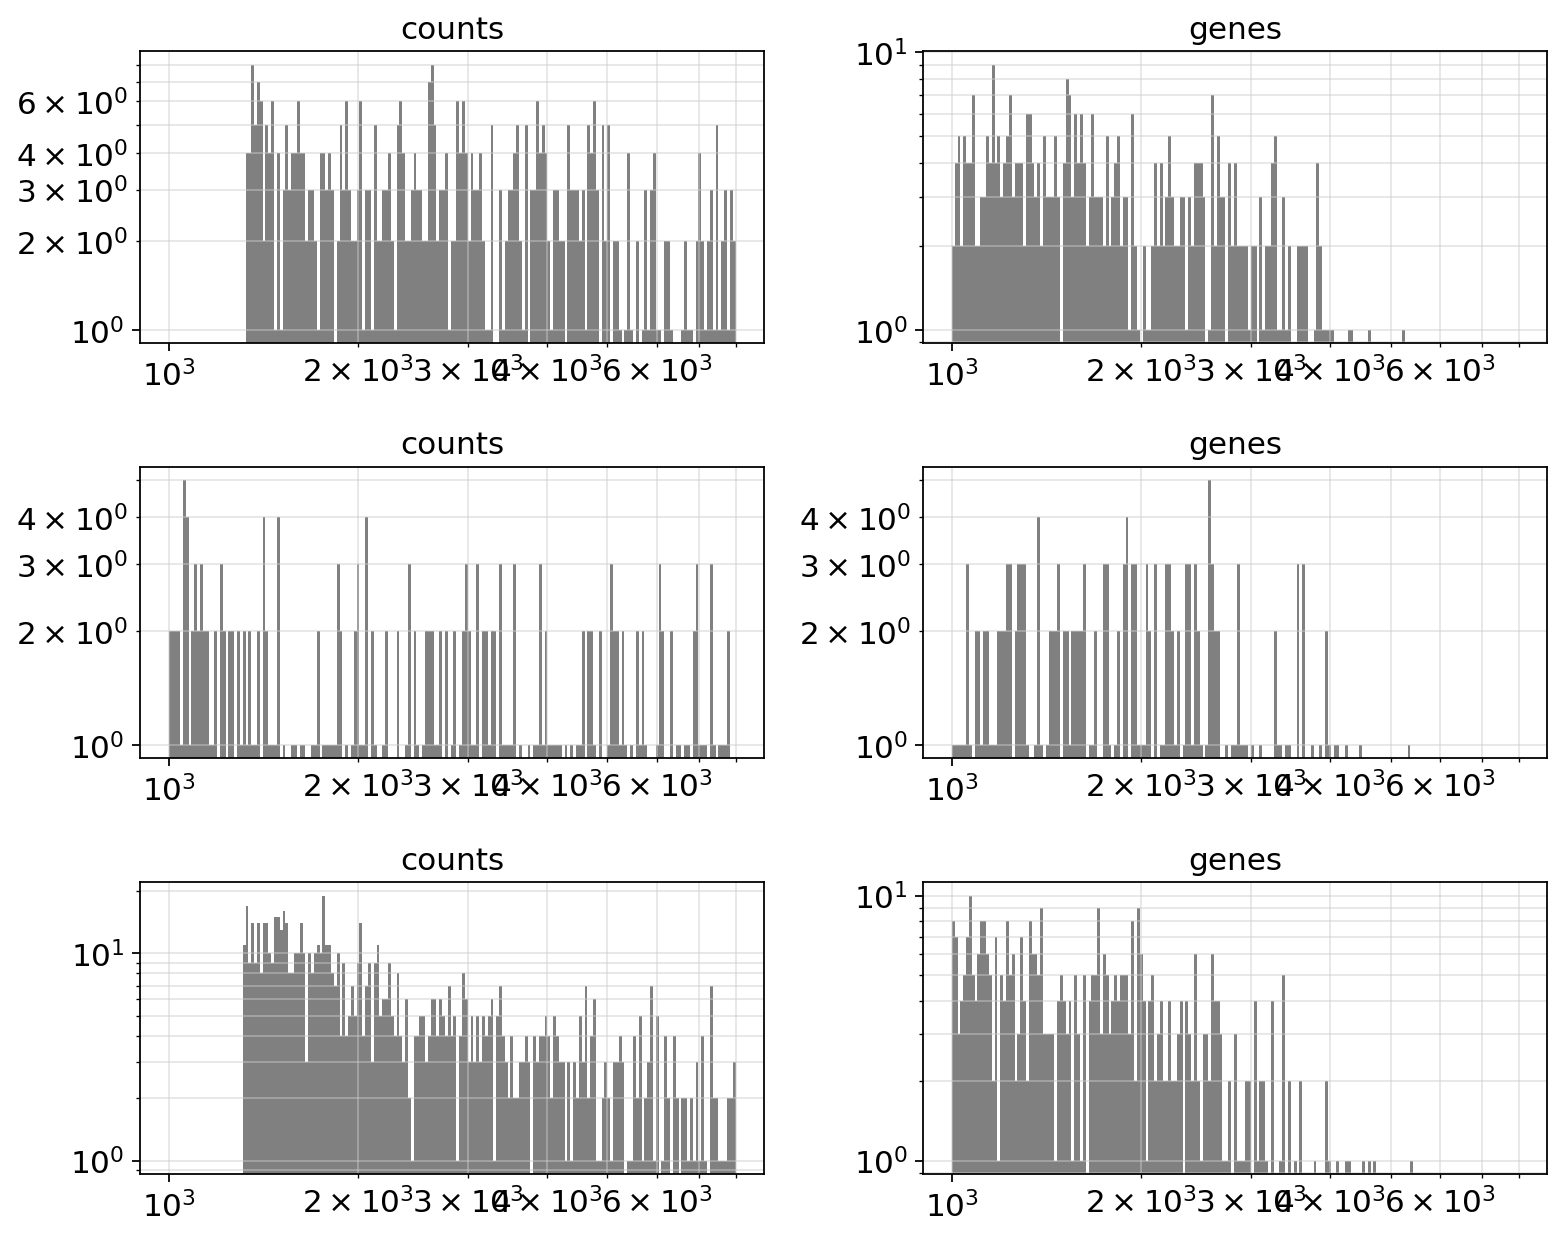

In [44]:
fig, axes = plt.subplots(3,2,figsize=(10,8))
for exp, row in tqdm(zip(exps, axes),total=3):
    vals = sc.pp.filter_cells(exps[exp]['adata'], min_counts=0,inplace=False)[1] # total number of UMIs observed
    my_plot(row[0], vals, 'counts')
    
    vals = sc.pp.filter_cells(exps[exp]['adata'], min_genes=0,inplace=False)[1] # total number of UMIs observed
    my_plot(row[1], vals, 'genes')
        
plt.tight_layout()

Can't find mito genes, will comment this out for now.

In [55]:
# for exp in exps:
#     genelist = exps[exp]['adata'].var_names.tolist()

#     mito_genes_names = [gn for gn in genelist if gn.startswith('mt-')]

#     exps[exp]['mito_genes'] = [genelist.index(gn) for gn in mito_genes_names]

# for exp in exps:
#     exps[exp]['adata'].obs['percent_mito'] = np.ravel(np.sum(exps[exp]['adata'][:, exps[exp]['mito_genes']].X, axis=1)) / np.ravel(np.sum(exps[exp]['adata'].X, axis=1))

# fig, axes = plt.subplots(1,3,figsize=(15,5))
# for exp, ax in zip(exps,np.ravel(axes)):
#     ax.hist(exps[exp]['adata'].obs['percent_mito'].values,bins=200,density=True)
#     ax.set_title(exp)
#     ax.vlines(0.1,0,100,color='r')

In [66]:
def process1(adata):
    sc.pp.log1p(adata)
    sc.pp.normalize_per_cell(adata)
    return adata

In [67]:
for exp in exps:
    process1(exps[exp]['adata'])

    normalizing by total count per cell
        finished (0:00:00.01): normalized adata.X and added
        'n_counts', counts per cell before normalization (adata.obs)
    normalizing by total count per cell
        finished (0:00:00.01): normalized adata.X and added
        'n_counts', counts per cell before normalization (adata.obs)
    normalizing by total count per cell
        finished (0:00:00.02): normalized adata.X and added
        'n_counts', counts per cell before normalization (adata.obs)


In [127]:
def process2_check(adata,min_mean=0.0125):    # Extract out highly variable genes, but don't subset just yet.
    hv_adata = adata.copy()
    sc.pp.highly_variable_genes(hv_adata, flavor='seurat',inplace=True, min_mean=min_mean, n_bins=100)
    sc.pl.highly_variable_genes(hv_adata,log=False)
    plt.plot(hv_adata.var['means'].values,hv_adata.var['dispersions_norm'].values,linewidth=0,marker='.',markersize=1,color='gray')
    df = hv_adata.var[(hv_adata.var['means'] > 0.05) & (hv_adata.var['dispersions_norm'] > 0.5)].copy()
    plt.plot(df['means'].values,df['dispersions'].values,
             linewidth=0,marker='.',markersize=1,color='green')
    plt.xlim(-0.1,2)
    plt.show()

    extracting highly variable genes
    Gene indices [1050, 4708, 4726, 5654, 8999, 9483, 13041, 14183, 15725, 15732, 16995, 17661, 18090, 18091, 18443, 19267, 21447, 21448, 21951] fell into a single bin: their normalized dispersion was set to 1.
    Decreasing `n_bins` will likely avoid this effect.
        finished (0:00:01.20)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


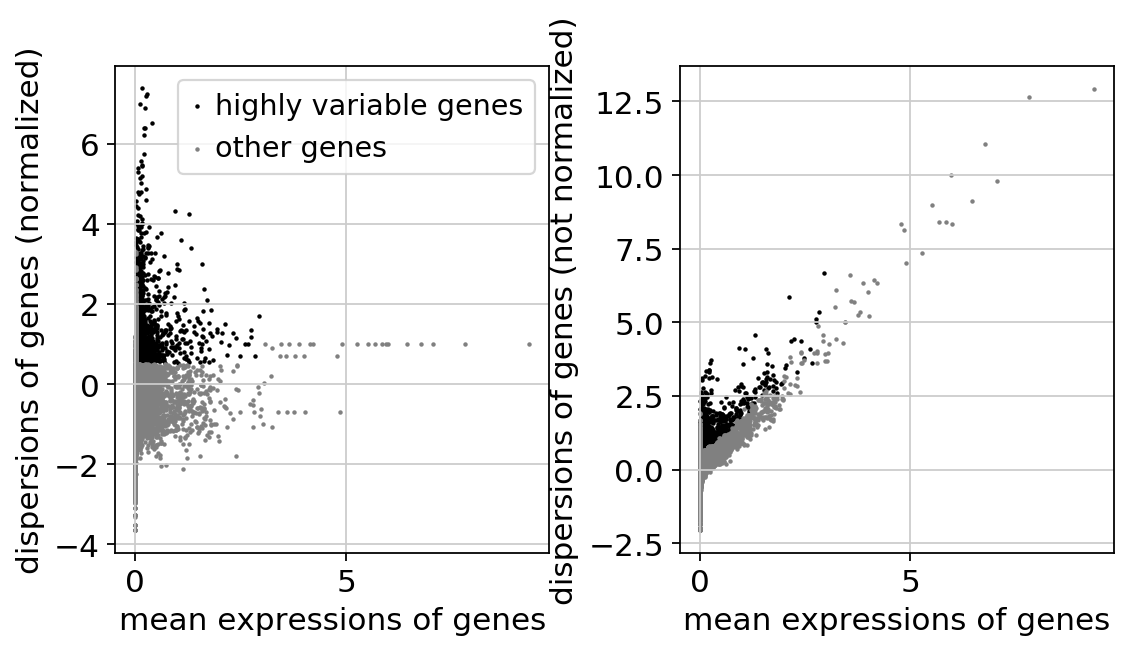

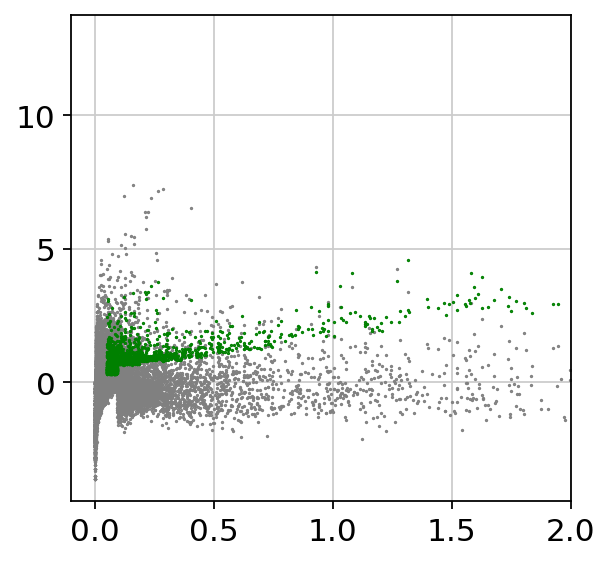

    extracting highly variable genes
    Gene indices [1050, 6483, 9483, 10084, 10201, 14183, 15732, 21447] fell into a single bin: their normalized dispersion was set to 1.
    Decreasing `n_bins` will likely avoid this effect.
        finished (0:00:01.17)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


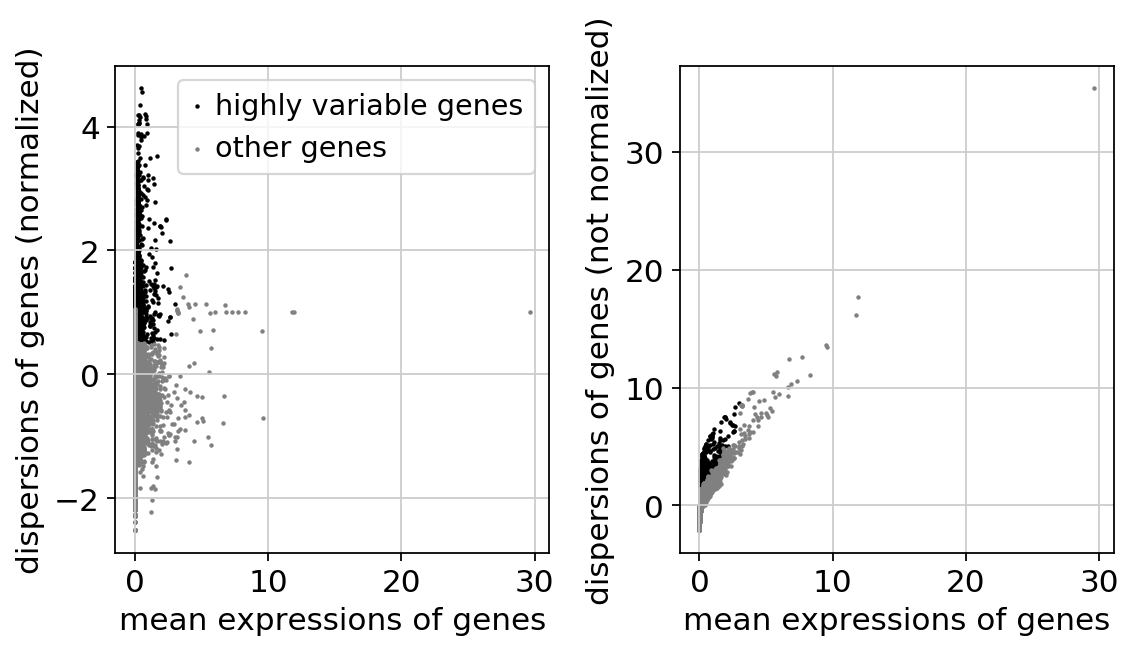

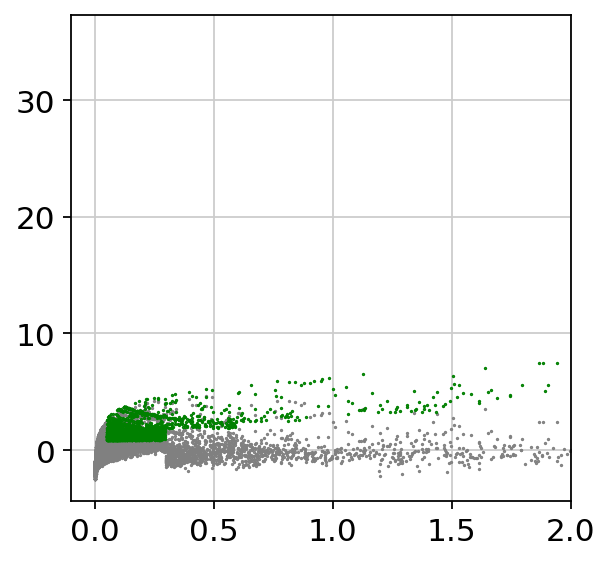

    extracting highly variable genes
    Gene indices [1050, 4709, 4710, 4711, 4712, 4726, 9483, 9994, 10204, 10583, 14182, 14183, 14417, 15725, 15732, 16995, 18090, 18091, 18657, 20747, 21447, 21951] fell into a single bin: their normalized dispersion was set to 1.
    Decreasing `n_bins` will likely avoid this effect.
        finished (0:00:01.31)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


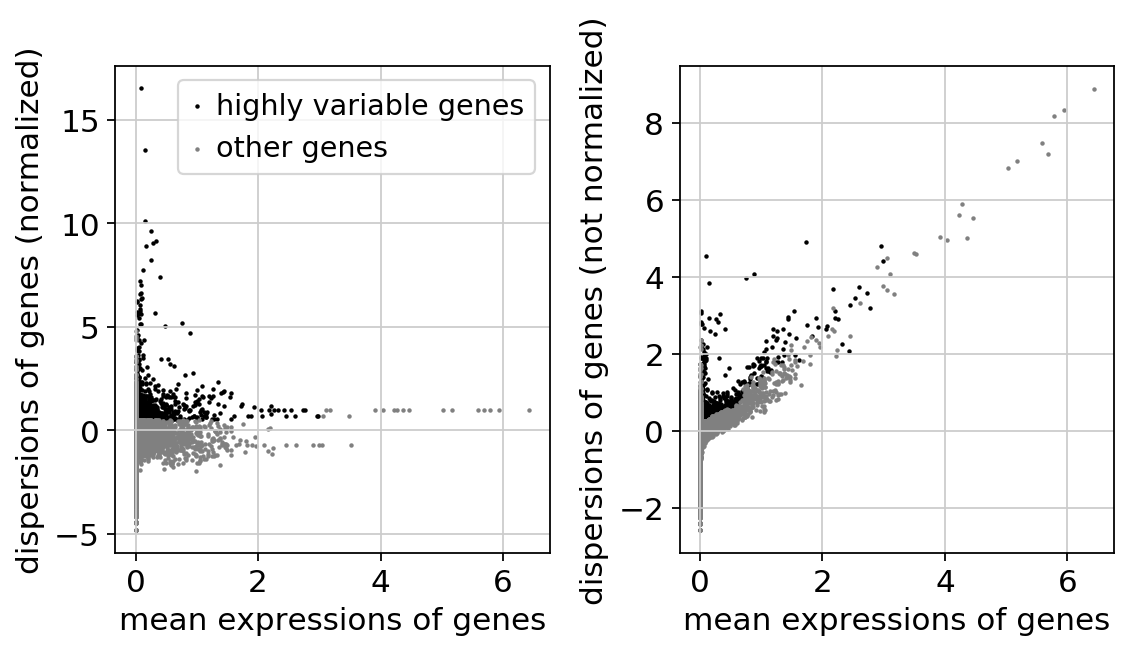

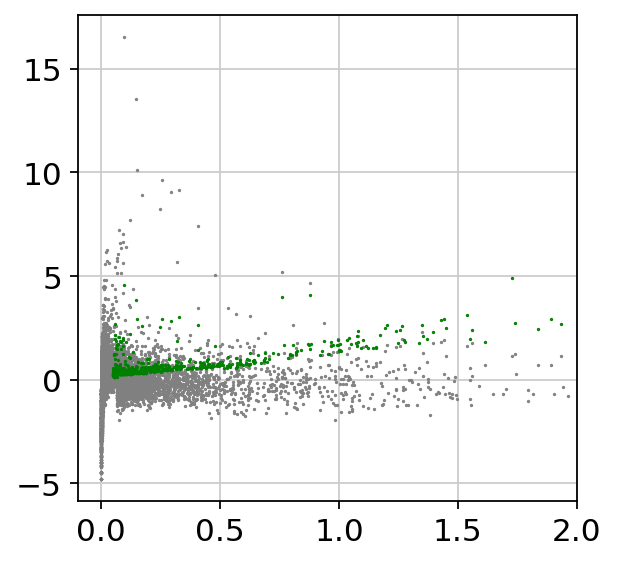

In [128]:
for exp in exps:
    process2_check(exps[exp]['adata'])

In [129]:
def process2(adata,min_mean=0.05):    # Extract out highly variable genes, but don't subset just yet.
    sc.pp.highly_variable_genes(adata, flavor='seurat',inplace=True, min_mean=min_mean, n_bins=100)

In [130]:
for exp in exps:
    process2(exps[exp]['adata'])

    extracting highly variable genes
    Gene indices [1050, 4708, 4726, 5654, 8999, 9483, 13041, 14183, 15725, 15732, 16995, 17661, 18090, 18091, 18443, 19267, 21447, 21448, 21951] fell into a single bin: their normalized dispersion was set to 1.
    Decreasing `n_bins` will likely avoid this effect.
        finished (0:00:01.19)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
    extracting highly variable genes
    Gene indices [1050, 6483, 9483, 10084, 10201, 14183, 15732, 21447] fell into a single bin: their normalized dispersion was set to 1.
    Decreasing `n_bins` will likely avoid this effect.
        finished (0:00:01.27)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
    extracting highly vari

Note that scikit-learn's randomized PCA might not be exactly reproducible across different computational platforms. For exact reproducibility, choose `svd_solver='arpack'.` This will likely become the Scanpy default in the future.
computing PCA with n_comps = 50
computing PCA on highly variable genes
        as `zero_center=True`, sparse input is densified and may lead to huge memory consumption
    finished (0:00:00.05)
    and added
    'X_pca', the PCA coordinates (adata.obs)
    'PC1', 'PC2', ..., the loadings (adata.var)
    'pca_variance', the variance / eigenvalues (adata.uns)
    'pca_variance_ratio', the variance ratio (adata.uns)


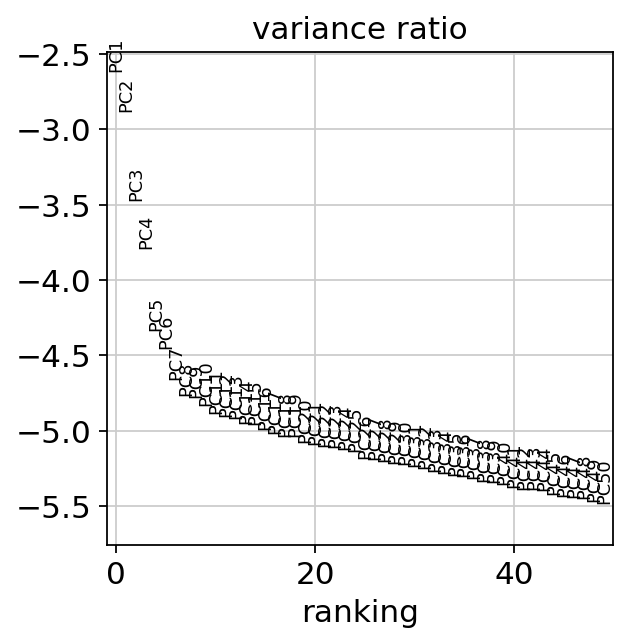

Note that scikit-learn's randomized PCA might not be exactly reproducible across different computational platforms. For exact reproducibility, choose `svd_solver='arpack'.` This will likely become the Scanpy default in the future.
computing PCA with n_comps = 50
computing PCA on highly variable genes
        as `zero_center=True`, sparse input is densified and may lead to huge memory consumption
    finished (0:00:00.03)
    and added
    'X_pca', the PCA coordinates (adata.obs)
    'PC1', 'PC2', ..., the loadings (adata.var)
    'pca_variance', the variance / eigenvalues (adata.uns)
    'pca_variance_ratio', the variance ratio (adata.uns)


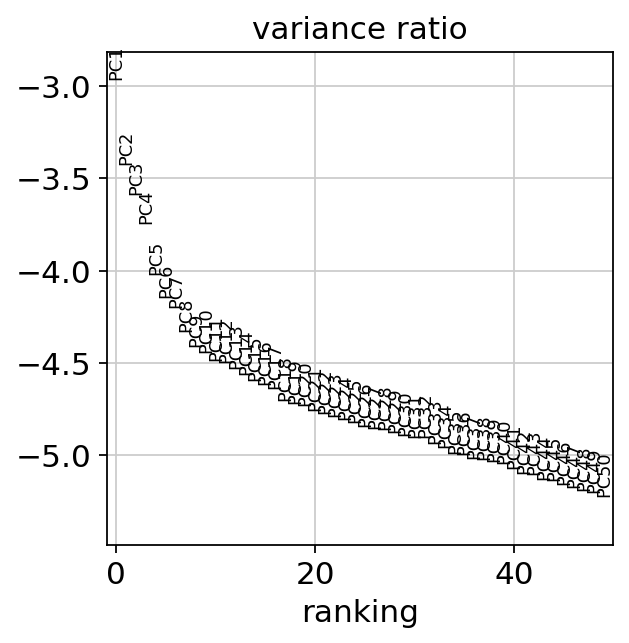

Note that scikit-learn's randomized PCA might not be exactly reproducible across different computational platforms. For exact reproducibility, choose `svd_solver='arpack'.` This will likely become the Scanpy default in the future.
computing PCA with n_comps = 50
computing PCA on highly variable genes
        as `zero_center=True`, sparse input is densified and may lead to huge memory consumption
    finished (0:00:00.04)
    and added
    'X_pca', the PCA coordinates (adata.obs)
    'PC1', 'PC2', ..., the loadings (adata.var)
    'pca_variance', the variance / eigenvalues (adata.uns)
    'pca_variance_ratio', the variance ratio (adata.uns)


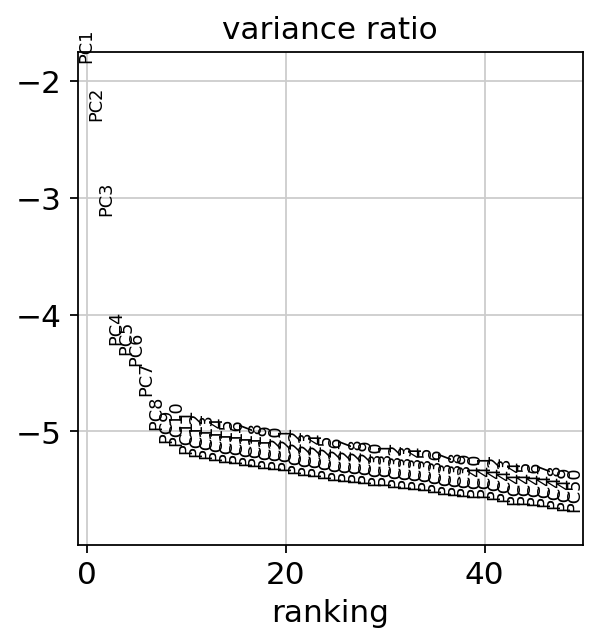

In [133]:
for exp in exps:
    sc.pp.pca(exps[exp]['adata'])
    sc.pl.pca_variance_ratio(exps[exp]['adata'],log=True, n_pcs=50)

In [134]:
npcs = [15, 20, 12]

In [139]:
for exp, npc in zip(exps,npcs):
    warnings.filterwarnings('ignore')
    sc.pp.neighbors(exps[exp]['adata'],n_neighbors=10,n_pcs=npc) # numba warning outlined here is not to be of concern: https://github.com/lmcinnes/umap/issues/252
    warnings.filterwarnings('default')
    sc.tl.leiden(exps[exp]['adata'],resolution=0.2)
    sc.tl.umap(exps[exp]['adata'], min_dist=.05, spread=5, alpha=2)

/usr/local/lib/python3.6/dist-packages/umap/umap_.py:1054: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/usr/local/lib/python3.6/dist-packages/umap/umap_.py:1054: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/usr/local/lib/python3.6/dist-packages/umap/umap_.py:1054: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/usr/local/lib/python3.6/dist-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


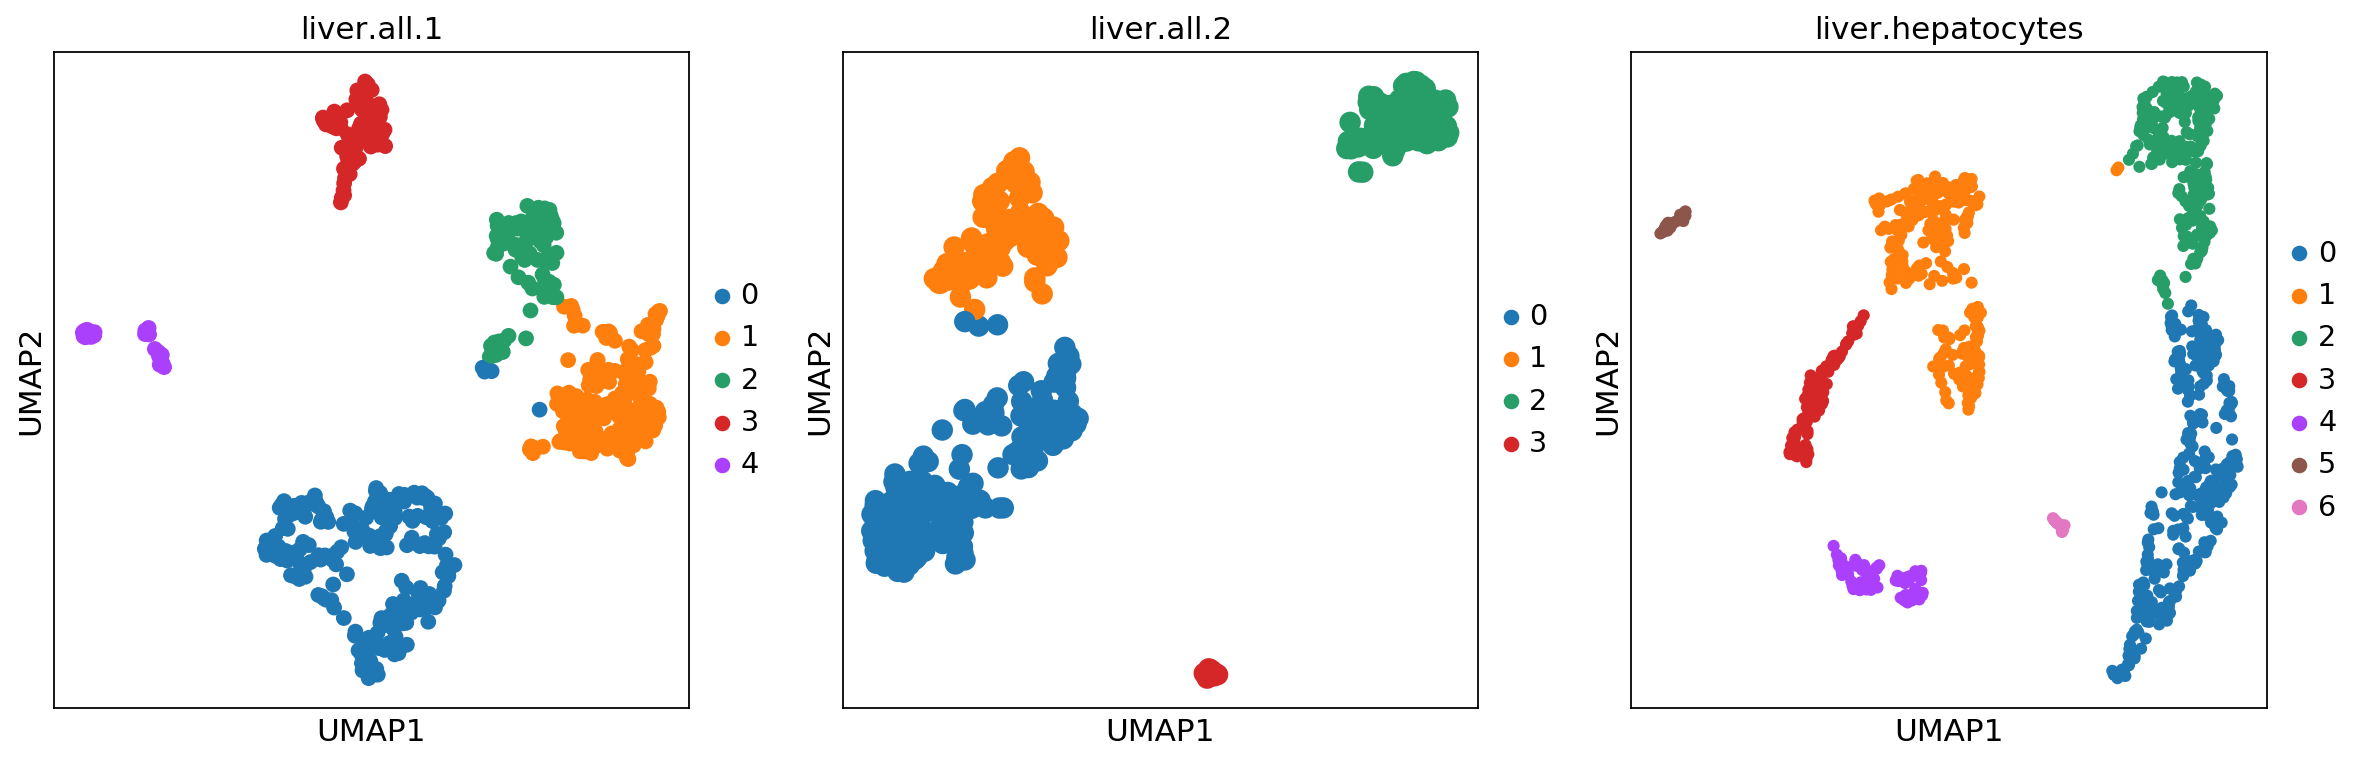

In [140]:
fig, axes = plt.subplots(1,3,figsize=(15,5))
for exp, ax in zip(exps, np.ravel(axes)):
    sc.pl.umap(exps[exp]['adata'],color='leiden',ax=ax, return_fig=False, show=False, title=exp)
plt.tight_layout()

/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
/usr/local/lib/python3.6/dist-

liver.all.1


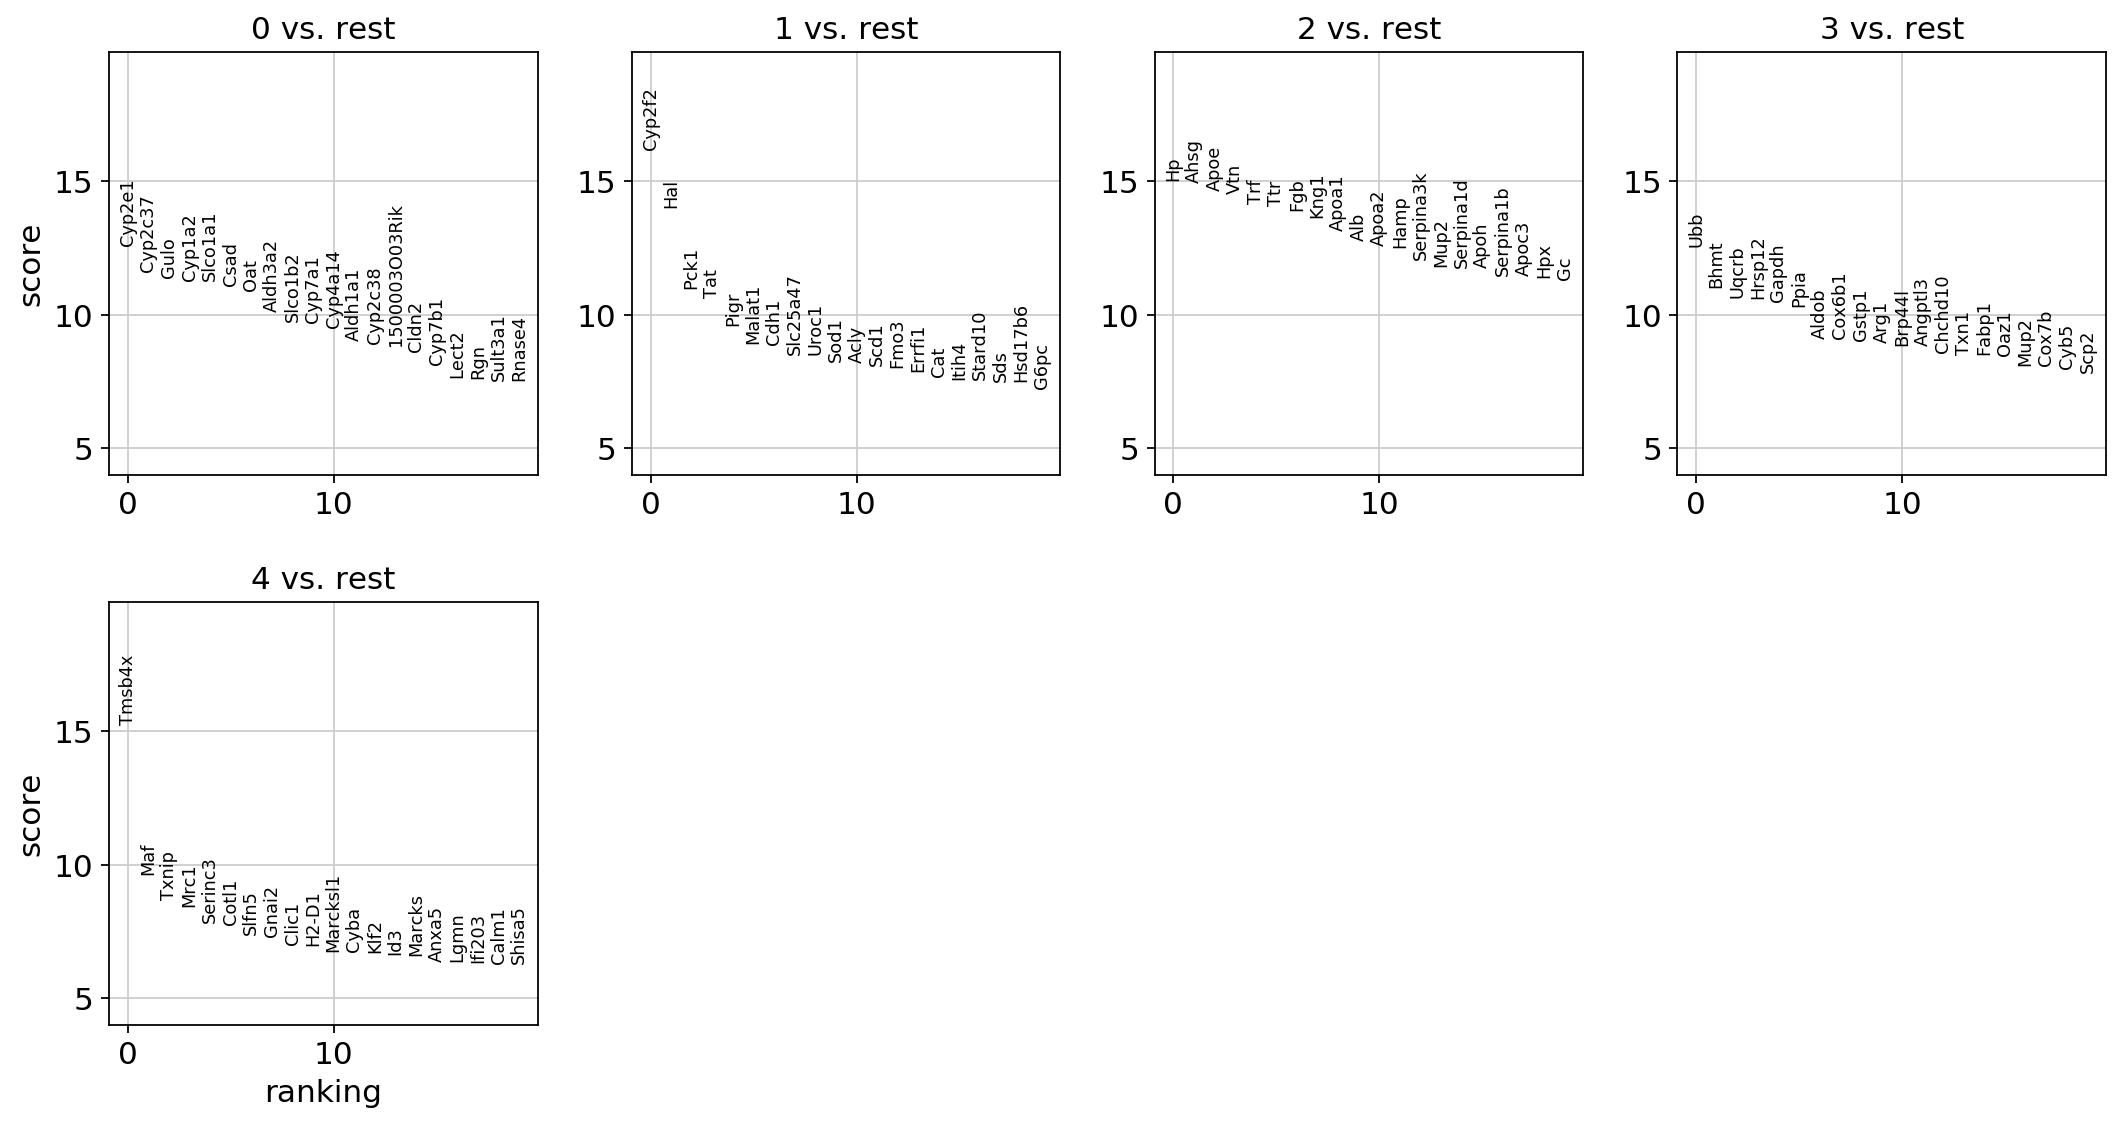

/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
/usr/local/lib/python3.6/dist-

liver.all.2


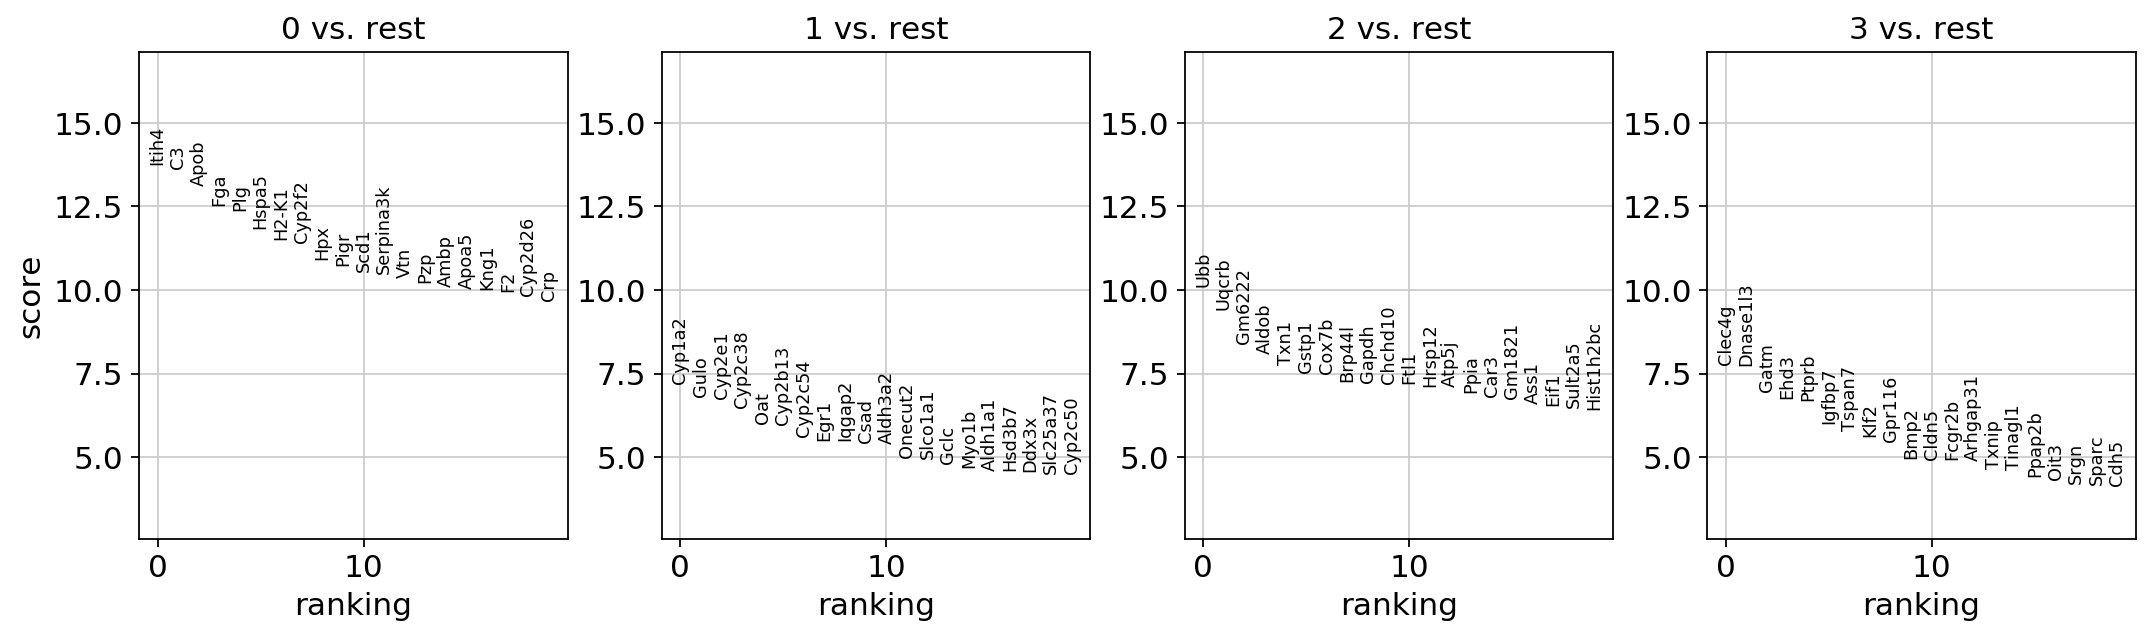

/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
/usr/local/lib/python3.6/dist-

liver.hepatocytes


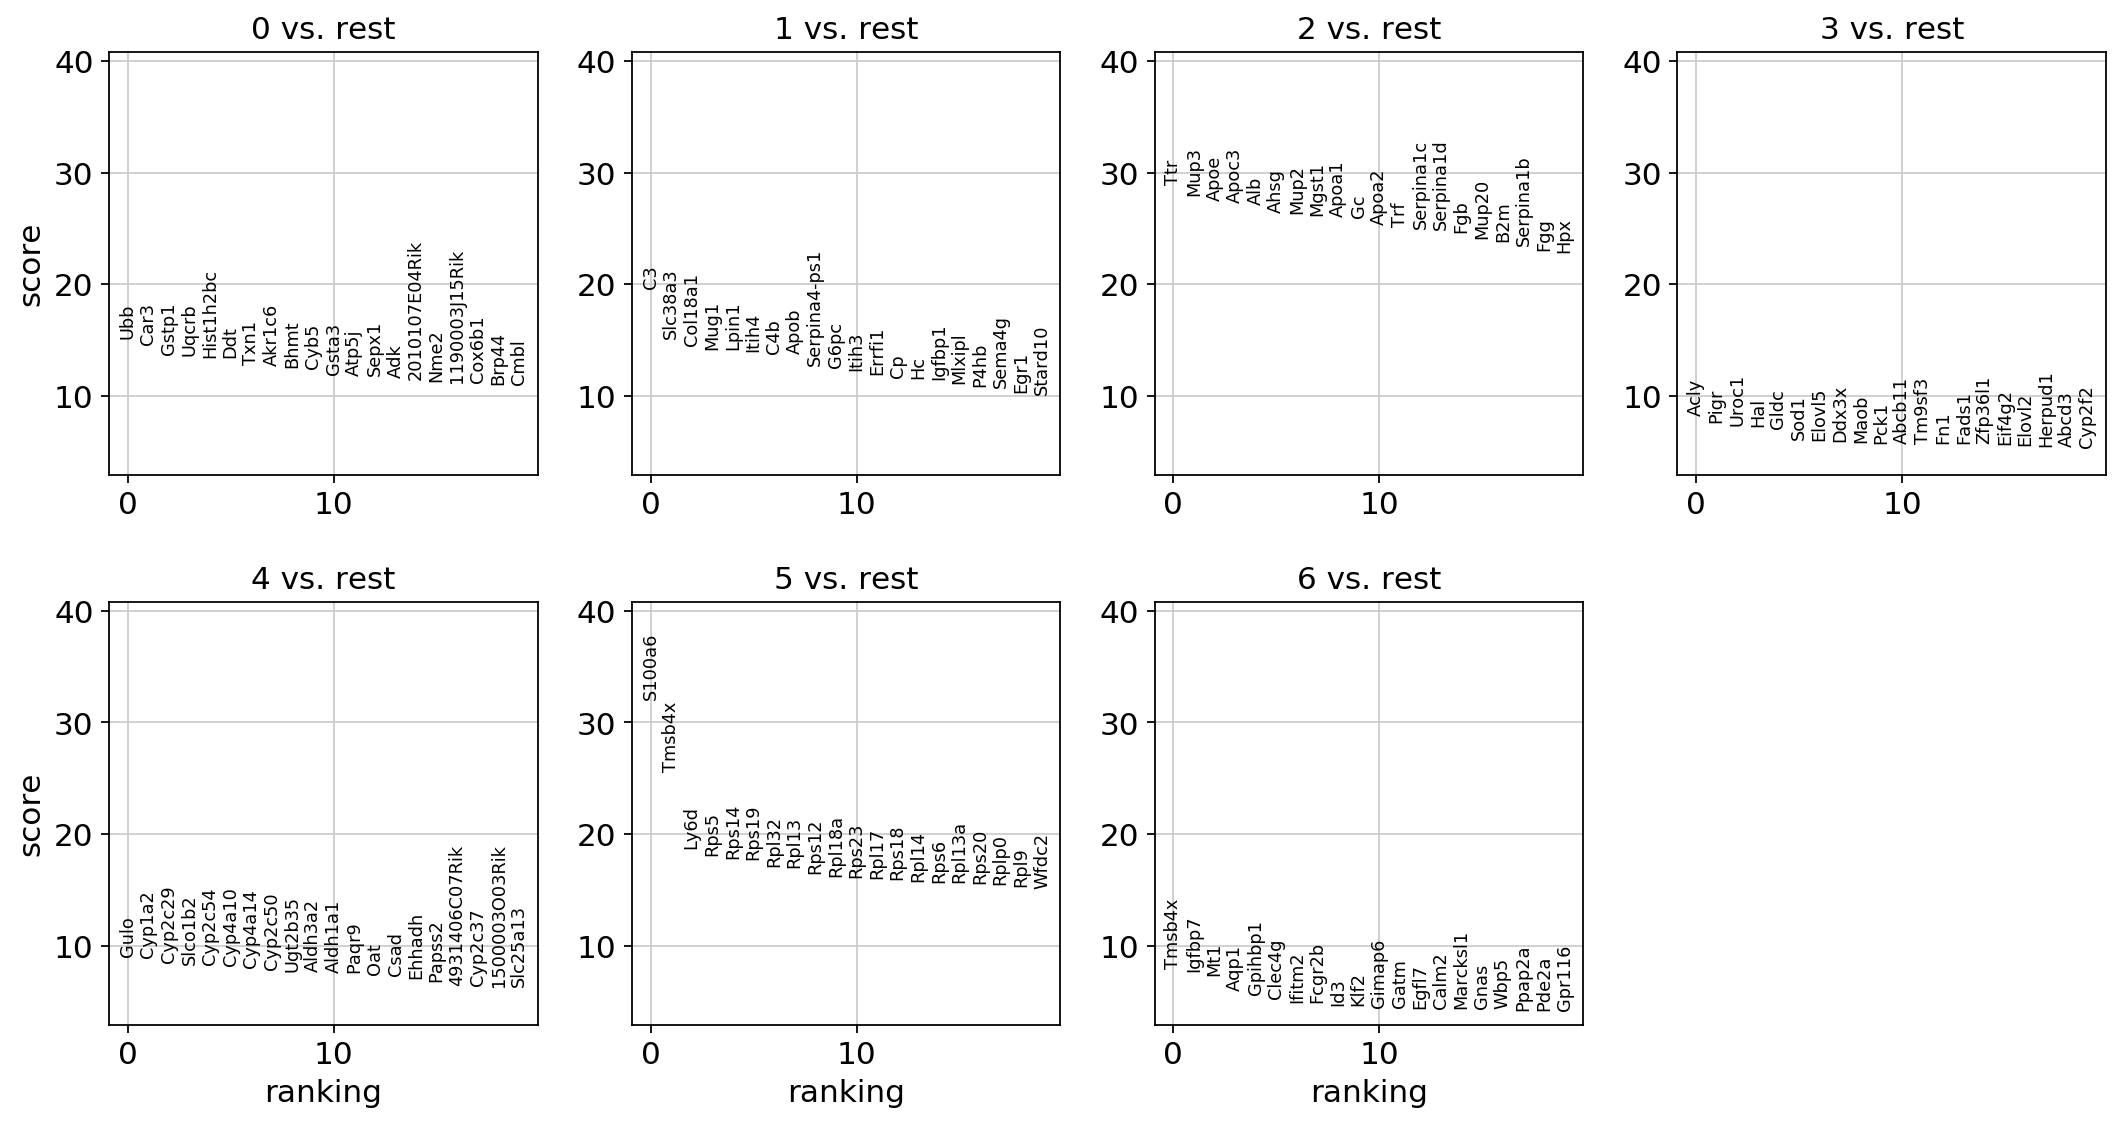

In [141]:
sc.settings.verbosity = 0
for exp in exps:
    sc.tl.rank_genes_groups(exps[exp]['adata'],groupby='leiden')
    print(exp)
    sc.pl.rank_genes_groups(exps[exp]['adata'])